In [1]:
# General imports
import numpy as np
import re
import sympy as sp
import json

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2, TwoLocal, RealAmplitudes
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize, differential_evolution, basinhopping

# Plotting functions
import matplotlib.pyplot as plt

# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

aer_sim = AerSimulator(method='statevector')
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)

In [2]:
def create_matrix(cut_off, type):
    # Initialize a zero matrix of the specified size
    matrix = np.zeros((cut_off, cut_off), dtype=np.complex128)
    
    # Fill the off-diagonal values with square roots of integers
    for i in range(cut_off):
        if i > 0:  # Fill left off-diagonal
            if type == 'q':
                matrix[i][i - 1] = (1/np.sqrt(2)) * np.sqrt(i)  # sqrt(i) for left off-diagonal
            else:
                matrix[i][i - 1] = (1j/np.sqrt(2)) * np.sqrt(i)

        if i < cut_off - 1:  # Fill right off-diagonal
            if type == 'q':
                matrix[i][i + 1] = (1/np.sqrt(2)) * np.sqrt(i + 1)  # sqrt(i + 1) for right off-diagonal
            else:
                matrix[i][i + 1] = (-1j/np.sqrt(2)) * np.sqrt(i + 1)

    return matrix

In [4]:
# Function to calculate the Hamiltonian
def calculate_Hamiltonian(cut_off):
    # Generate the position (q) and momentum (p) matrices
    q = create_matrix(cut_off, 'q')  # q matrix
    p = create_matrix(cut_off, 'p')  # p matrix
    
    #fermionic identity
    I_f = np.eye(2)

    # Calculate q^2 and q^3 for potential terms
    q2 = np.dot(q, q)
    q3 = np.dot(q2, q)
    
    # Superpotential derivatives
    W_prime = q + q3  # W'(q) = q + q^3
    W_double_prime = np.eye(cut_off) + 3 * q2  # W''(q) = 1 + 3q^2

    # Kinetic term: p^2
    p2 = np.dot(p, p)

    # Commutator term [b^†, b] = -Z
    Z = np.array([[1, 0], [0, -1]])  # Pauli Z matrix for fermion number
    commutator_term = np.kron(Z, W_double_prime)

    # Construct the block-diagonal kinetic term (bosonic and fermionic parts)
    # Bosonic part is the same for both, hence we use kron with the identity matrix
    kinetic_term = np.kron(I_f, p2)

    # Potential term (W' contribution)
    potential_term = np.kron(I_f, np.dot(W_prime, W_prime))

    # Construct the full Hamiltonian
    H_SQM = 0.5 * (kinetic_term + potential_term + commutator_term)

    return H_SQM

In [7]:
H = calculate_Hamiltonian(32)

In [15]:
eigenvalues = np.sort(np.linalg.eig(H)[0])
min_eigenvalue = min(eigenvalues.real)

In [17]:
min_eigenvalue

6.182238711933954e-06

In [16]:
eigenvalues

array([6.18223871e-06+0.j, 1.68649858e+00+0.j, 1.68655905e+00+0.j,
       4.37176187e+00+0.j, 4.37284211e+00+0.j, 7.63057941e+00+0.j,
       7.63575992e+00+0.j, 1.13727964e+01+0.j, 1.13774139e+01+0.j,
       1.53965493e+01+0.j, 1.55535629e+01+0.j, 1.96911892e+01+0.j,
       2.01186575e+01+0.j, 2.29381976e+01+0.j, 2.47872393e+01+0.j,
       2.58260742e+01+0.j, 3.21153768e+01+0.j, 3.34958952e+01+0.j,
       4.21506074e+01+0.j, 4.33739156e+01+0.j, 7.85632154e+01+0.j,
       7.96172963e+01+0.j, 9.36370296e+01+0.j, 9.46688094e+01+0.j,
       1.92403714e+02+0.j, 1.93383701e+02+0.j, 2.13321134e+02+0.j,
       2.14297411e+02+0.j, 4.38223569e+02+0.j, 4.39189328e+02+0.j,
       4.66086353e+02+0.j, 4.67051349e+02+0.j, 9.28210873e+02+0.j,
       9.29177073e+02+0.j, 9.64241361e+02+0.j, 9.65207387e+02+0.j,
       1.85045427e+03+0.j, 1.85142449e+03+0.j, 1.89600838e+03+0.j,
       1.89697856e+03+0.j, 3.51660223e+03+0.j, 3.51757693e+03+0.j,
       3.57321540e+03+0.j, 3.57419009e+03+0.j, 6.44633547e+03+

In [7]:
#sympy_matrix = sp.Matrix(H)
#sp.pprint(sympy_matrix, use_unicode=True)

In [9]:
hamiltonian = SparsePauliOp.from_operator(H)
ansatz = RealAmplitudes(num_qubits=hamiltonian.num_qubits, reps=1)
ansatz_isa = pm.run(ansatz)
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [10]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub], precision=0.01).result()
    #result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    #if cost_history_dict['iters'] % 100 == 0:
    #    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [13]:
num_params = ansatz.num_parameters
x0 = 2* np.pi * np.random.random(num_params)
x0 = [
            6.3053586558690125,
            0.016261306285997725,
            3.13642321718868,
            3.1314205050912345,
            3.17097097410043,
            1.857299210147821,
            0.08434299912847182,
            6.241173798515077,
            3.169118872704756,
            6.2829736649096395,
            6.315546290692929,
            1.8166471119799585
        ]

In [21]:
energies = []
x_values = []

backend=aer_sim
estimator = Estimator(mode=backend)

for i in range(100):

    if i % 10 == 0:
        print(f"Run: {i}")

    res = minimize(
        cost_func,
        x0,
        method= "COBYLA",
        args= (ansatz_isa, hamiltonian_isa, estimator),
        options= {'maxiter':10000}
    )
    energies.append(res.fun)
    x_values.append(res.x)

    closest_e = min(enumerate(energies), key=lambda x: abs(x[1] - min_eigenvalue))[0]
    closest_x = x_values[closest_e]
    x0 = closest_x

Run: 0


KeyboardInterrupt: 

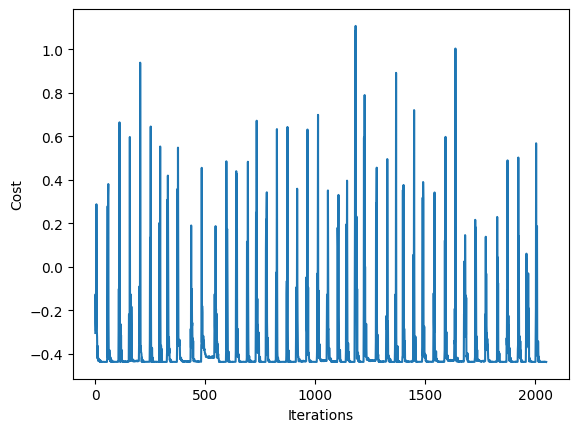

In [20]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [11]:
run = {
    'potential': 'AHO',
    'cutoff': 16,
    'ansatz': 'RealAmplitudes',
    'num_sessions': 100,
    'backend': 'aer_simulator',
    'estimator_shots': 10000,
    'min_function': {'name': 'basinhopping',
                     'args': {'minimizer_kwargs': {'method': "COBYLA",
                                                    "args": ('ansatz_isa', 'hamiltonian_isa', 'estimator'),
                                                    "options": {'maxiter':1000}},   
                                'niter': 3,
                                'T': 0.25}
                    },
    'results': energies,
    'x_values': [x.tolist() for x in x_values]
}

In [12]:
path = r"C:\Users\Johnk\OneDrive\Desktop\PhD 2024\Quantum Computing Code\Quantum-Computing\Qiskit\SUSY VQE\Files\AHO\AHO_16.json"
# Save the variable to a JSON file
with open(path, 'w') as json_file:
    json.dump(run, json_file, indent=4)

In [13]:
n_values = [2, 4, 8, 16]
data_dict = {}

base_path = r"C:\Users\Johnk\OneDrive\Desktop\PhD 2024\Quantum Computing Code\Quantum-Computing\Qiskit\SUSY VQE\Files\AHO\AHO_{}.json"

for n in n_values:
    file_path = base_path.format(n)
    with open(file_path, 'r') as json_file:
        data_dict[f'c{n}'] = json.load(json_file)

In [14]:
for c in data_dict.keys():
    res = [x for x in data_dict[c]['results']]
    print(c)
    print("Min: ", min(res))
    print("Avg: ", np.mean(res))

c2
Min:  -0.4375
Avg:  -0.4374975
c4
Min:  -0.24108233132392165
Avg:  -0.1333196277260035
c8
Min:  -0.8417416284745765
Avg:  1.6553677447548585
c16
Min:  -28.926533464003278
Avg:  3.549705413130431
